In [6]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd, numpy as np
import feather, h5py
import matplotlib.pyplot as plt
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Merge the outputs of the optimization model with the power plant characteristics

In [7]:
#gen = feather.read_dataframe('/home/gchossie/epa_ace/outputs/gen_orig_alan_v2.feather')
gen = feather.read_dataframe('./outputs/eia_2030_regional_floats/gen_no-nuclear_EIA_2030_renewables.feather')

In [8]:
#read in the characteristics
carac = pd.read_csv('./good_model_inputs/inputs_gen_no-nuclear_EIA_2030_renewables.csv')
#assign a generation column based on the gen df
carac['generation'] = gen.sum(axis=1)
#calculate capacity factor
carac['capafac'] = carac['generation'] / (8759 * carac['Capacity'])

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Check the capacity factors

In [9]:
carac.loc[carac['capafac'] > 1.01, :]

,Unnamed: 0,RegionName,FuelType,FuelCostTotal,PLCO2RTA,ORISCode,DIVISIONCE,UNITID,Capacity,OBJECTID,...,PLN2ORTA,PLCH4RTA,PRMVR,FUELU1,pm.mmbtu,pm.mwh,generationCO2,g,generation,capafac


# Import eGrid data

In [10]:
egrid = feather.read_dataframe('./good_model_inputs/egrid.feather')

In [9]:
# convert us names to abbreviations
us_state_abbrev={'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',\
                'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia':\
                'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho':\
                'ID','Illinois': 'IL','Indiana': 'IN','Iowa':'IA','Kansas': 'KS','Kentucky': 'KY',\
                'Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA',\
                'Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO',\
                'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH',\
                 'New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC',\
                 'North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK',\
                 'Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI',\
                 'South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT',\
                 'Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia':\
                 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

## Plot generation by state

In [10]:
carac['StateAbb'] = carac['StateName'].apply(lambda x: us_state_abbrev[x])

In [11]:
tmp = pd.concat([egrid.groupby('SUBRGN')['PLNGENAN'].sum(), carac.groupby('SUBRGN')['generation'].sum()], axis=1)

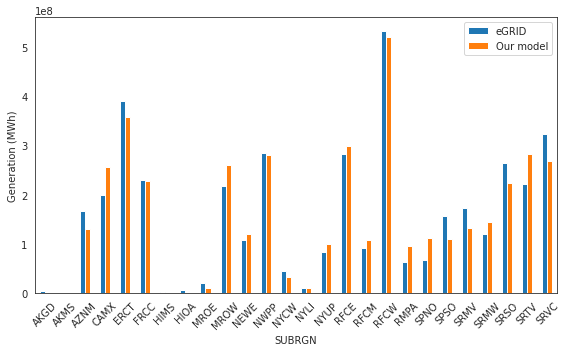

In [12]:
sns.set_style('white')
fig, ax = plt.subplots(1,1, figsize=(8,5))
tmp.rename(columns={'PLNGENAN': 'eGRID', 'generation': 'Our model'}).plot.bar(ax=ax)
ax.set_ylabel('Generation (MWh)')
kw = {'rotation': 45}
ax.set_xticklabels(ax.get_xticklabels(), **kw)
fig.tight_layout()
#plt.savefig('gen_per_state.png', dpi=300)

In [13]:
egrid.groupby(['SUBRGN','PLFUELCT'])['PLNGENAN'].sum().loc['SPSO']

PLFUELCT
BIOMASS    2.307505e+06
COAL       6.094964e+07
GAS        6.061905e+07
HYDRO      5.668096e+06
OFSL       1.395410e+05
OIL        1.193003e+03
OTHF       8.512800e+04
SOLAR      1.638370e+05
WIND       2.684675e+07
Name: PLNGENAN, dtype: float64

In [14]:
carac.groupby(['StateAbb', 'FuelType'])['PLNOXRTA'].mean().loc['IN']

FuelType
Coal                 1.637710
Hydro                     NaN
LF Gas               6.948892
MSW                  1.287742
NaturalGas           0.646177
Non-Fossil          19.418037
Oil                121.760392
Solar                     NaN
Wind                      NaN
solar_generator      0.000000
wind_generator       0.000000
Name: PLNOXRTA, dtype: float64

In [15]:
carac.groupby(['StateAbb', 'FuelType'])['generation'].sum().loc['IN'].sort_values(ascending=False)

FuelType
Coal               8.267048e+07
NaturalGas         1.532800e+07
Wind               6.600246e+06
wind_generator     5.013252e+06
solar_generator    1.872850e+06
LF Gas             4.992630e+05
Hydro              1.334171e+05
Solar              1.157598e+05
MSW                4.379500e+04
Non-Fossil         3.503600e+04
Oil                0.000000e+00
Name: generation, dtype: float64

In [16]:
egrid.groupby(['PSTATABB','PLFUELCT'])['PLNOXAN'].mean().loc['IN'] * 907.185

PLFUELCT
BIOMASS    2.179130e+05
COAL       3.755627e+06
GAS        1.091278e+05
HYDRO               NaN
OFSL       1.282329e+05
OIL        1.013326e+03
OTHF       1.355929e+05
SOLAR               NaN
WIND                NaN
Name: PLNOXAN, dtype: float64

## Plot generation by primary fuel type

In [17]:
egrid.loc[pd.isnull(egrid['PLFUELCT']), 'PLFUELCT'] = ''

In [18]:
# Translate eGrid fuel cat name to ours
egrid.loc[pd.isnull(egrid['PLFUELCT']), 'PLFUELCT'] = ''
egrid['PLFUELCT'] = egrid['PLFUELCT'].apply(lambda x: x[:1].upper() + x[1:].lower())

In [19]:
#rename gas to natural gas
egrid.loc[egrid['PLFUELCT'] == 'Gas', 'PLFUELCT'] = 'NaturalGas'

In [20]:
# Regroup hydro and pumps
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro'

In [21]:
tmp = pd.concat([egrid.groupby('PLFUELCT')['PLNGENAN'].sum(), carac.groupby('FuelType')['generation'].sum()], axis=1)

In [22]:
reg = 'RFCE'
sube = egrid.loc[egrid['SUBRGN'] == reg].groupby('PLFUELCT')['PLNGENAN'].sum()
subc = carac.loc[carac['SUBRGN'] == reg].groupby('FuelType')['generation'].sum()
tmp = pd.DataFrame({'egrid': sube, 'Me': subc})

<AxesSubplot:xlabel='FuelType'>

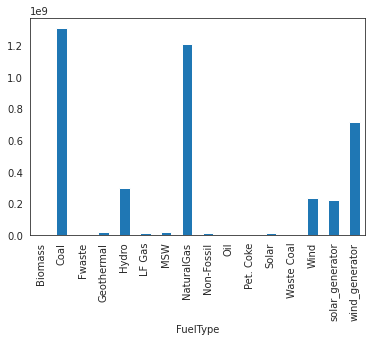

In [23]:
carac.groupby('FuelType')['generation'].sum().plot.bar()

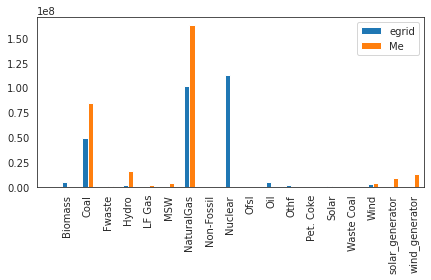

In [24]:
fig, ax = plt.subplots()
tmp.plot.bar(ax=ax)
fig.tight_layout()

In [25]:
tmp = pd.concat([egrid.groupby('PLPRMFL')['PLNGENAN'].sum(), carac.groupby('FUELU1')['generation'].sum()], axis=1)

In [26]:
egrid['PLCO2AN'].sum()*.907

1845281822.142205

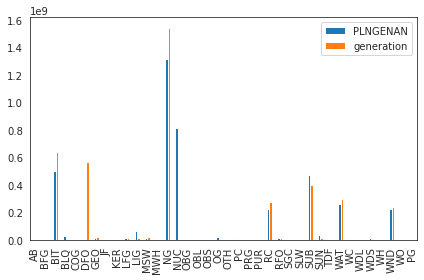

In [27]:
fig, ax = plt.subplots()
tmp.plot.bar(ax=ax)
fig.tight_layout()

# Compute emissions

In [28]:
# Import needs emissions
#needs = pd.read_excel('./good_model_inputs/needs_v6_12-18-2019.xlsx', sheet_name='NEEDS v6_active')

In [29]:
#tst = needs[['UniqueID_Final', 'Heat Rate (Btu/kWh)','Mode 2 NOx Rate (lbs/mmBtu)','SO2 Permit Rate (lbs/mmBtu)']]
#mgd = carac.rename(columns={'UniqueID': 'UniqueID_Final'}).merge(tst, on='UniqueID_Final', how='outer')
#mgd['NOX emissions (kg)'] = carac['generation'] * mgd['Heat Rate (Btu/kWh)'] * mgd['Mode 2 NOx Rate (lbs/mmBtu)'] * 1e-3 * 0.45359 # 0.45 kg / lb
#mgd['SO2 emissions (kg)'] = carac['generation'] * mgd['Heat Rate (Btu/kWh)'] * mgd['SO2 Permit Rate (lbs/mmBtu)'] * 1e-3 * 0.45359

In [30]:
# emissions in kg
region_tots = feather.read_dataframe('./good_model_inputs/egrid_corr_fac.feather').set_index('index')
carac['NOX corr'] = carac['SUBRGN'].apply(lambda x: region_tots['NOX corr fac'][x])
carac['SO2 corr'] = carac['SUBRGN'].apply(lambda x: region_tots['SO2 corr fac'][x])
carac['NOX emissions (kg)'] = carac['generation'] * carac['PLNOXRTA']# * carac['NOX corr']
carac['SO2 emissions (kg)'] = carac['generation'] * carac['PLSO2RTA'] #* carac['SO2 corr']
carac['N2O emissions (kg)'] = carac['generation'] * carac['PLN2ORTA']
carac['CH4 emissions (kg)'] = carac['generation'] * carac['PLCH4RTA']
carac['CO2 emissions (kg)'] = carac['generation'] * carac['PLCO2RTA']

In [31]:
poll = 'CO2'
df = carac
print((df[f'{poll} emissions (kg)'].sum() - egrid[f'PL{poll}AN'].sum()*907.185) / (egrid[f'PL{poll}AN'].sum()*907.185))
#tmp = pd.concat([egrid.groupby('PLPRMFL')[f'PL{poll}AN'].sum(), carac.groupby('FUELU1')[f'{poll} emissions (kg)'].sum()], axis=1, sort=True)
tmp = pd.concat([egrid.groupby('SUBRGN')[f'PL{poll}AN'].sum(), df.groupby('SUBRGN')[f'{poll} emissions (kg)'].sum()], axis=1, sort=True)
tmp[f'PL{poll}AN'] *= 907.185 #kg / sort ton

0.0032752521240891172


In [32]:
tmp

,PLCO2AN,CO2 emissions (kg)
SUBRGN,,
AKGD,2.288562e+09,NaN
AKMS,3.719237e+08,NaN
AZNM,7.873777e+10,1.977760e+10
CAMX,4.803114e+10,1.131089e+10
ERCT,1.784930e+11,1.072078e+11
FRCC,1.052734e+11,1.026962e+11
HIMS,1.432666e+09,NaN
HIOA,5.436155e+09,NaN
MROE,1.549082e+10,8.111639e+08


In [33]:
tmp[f'{poll} emissions (kg)'].sum()

1851703198616.8518

In [34]:
tmp[f'{poll} emissions (kg)'].sum()

1851703198616.8518

In [35]:
tmp[f'PL{poll}AN'].sum()

1845658202668.2207

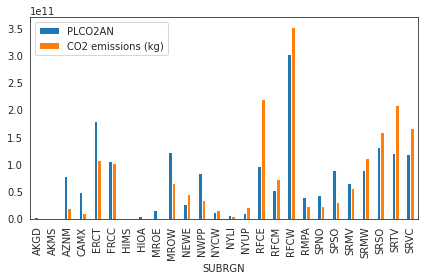

In [36]:
fig, ax = plt.subplots()
tmp.plot.bar(ax=ax)
fig.tight_layout()

In [37]:
reg = 'NWPP'
df = carac
sp = 'SO2'
print('Mean :', df.loc[df['SUBRGN'] == reg, f'PL{sp}RTA'].mean(), ' Max :', df.loc[df['SUBRGN'] == reg, f'PL{sp}RTA'].max(),' Min :', df.loc[df['SUBRGN'] == reg, f'PL{sp}RTA'].min())
print('Generation-weighted mean: ', (df.loc[df['SUBRGN'] == reg, f'{sp} emissions (kg)']).sum()/\
    df.loc[df['SUBRGN'] == reg, 'generation'].sum())

Mean : 0.3099530462340865  Max : 15.08549622  Min : 0.0
Generation-weighted mean:  0.05227697720901102


In [38]:
print('Mean :',  0.45359 *egrid.loc[carac['SUBRGN'] == reg, f'PL{sp}RTA'].mean(),' Max :',  0.45359 *egrid.loc[egrid['SUBRGN'] == reg, f'PL{sp}RTA'].max(),' Min :',  0.45359 *egrid.loc[egrid['SUBRGN'] == reg, f'PL{sp}RTA'].min())
print('Generation-weighted mean: ', 0.45359 * (egrid.loc[egrid['SUBRGN'] == reg, f'PL{sp}RTA'] * egrid.loc[egrid['SUBRGN'] == reg, 'PLNGENAN']).sum()/\
    egrid.loc[egrid['SUBRGN'] == reg, 'PLNGENAN'].sum())

Mean : 0.9448279700000001  Max : 15.085496220000001  Min : 0.0
Generation-weighted mean:  0.1993382001348433


### Compute correction factor to match region wide emissions with eGRID

In [73]:
# Compute total and eGRID total by region
df = carac
region_tots = pd.DataFrame([], index=set(df['SUBRGN']))
for poll in ['SO2', 'NOX']:
    tmp = pd.concat([egrid.groupby('SUBRGN')[f'PL{poll}AN'].sum(), df.groupby('SUBRGN')[f'{poll} emissions (kg)'].sum()], axis=1, sort=True)
    tmp[f'PL{poll}AN'] *= 907.185 #kg / sort ton
    tmp = tmp.dropna()
    region_tots[f'my {poll}'] = tmp[f'{poll} emissions (kg)']
    region_tots[f'egrid {poll}'] = tmp[f'PL{poll}AN']
    region_tots[f'{poll} corr fac'] = region_tots[f'egrid {poll}'] / region_tots[f'my {poll}']

In [82]:
region_tots.reset_index(drop=False).to_feather('egrid_corr_fac.feather')

In [78]:
df['NOX corr'] = df['SUBRGN'].apply(lambda x: region_tots['NOX corr fac'][x])
df['SO2 corr'] = df['SUBRGN'].apply(lambda x: region_tots['SO2 corr fac'][x])

In [79]:
df.head()

,Unnamed: 0,RegionName,FuelType,FuelCostTotal,PLCO2RTA,ORISCode,DIVISIONCE,UNITID,Capacity,OBJECTID,...,generation,capafac,StateAbb,NOX emissions (kg),SO2 emissions (kg),N2O emissions (kg),CH4 emissions (kg),CO2 emissions (kg),NOX corr,SO2 corr
0,0,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,GTG1,155.0,12038.0,...,0.0,0.0,TX,0.0,0.0,0.0,0.0,0.0,1.659633,1.33184
1,1,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,GTG2,155.0,12037.0,...,0.0,0.0,TX,0.0,0.0,0.0,0.0,0.0,1.659633,1.33184
2,2,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,GTG3,155.0,12040.0,...,0.0,0.0,TX,0.0,0.0,0.0,0.0,0.0,1.659633,1.33184
3,3,ERC_FRNT,NaturalGas,19.686689,395.819870,55062,WSC-TX,STG1,395.0,12039.0,...,0.0,0.0,TX,0.0,0.0,0.0,0.0,0.0,1.659633,1.33184
4,4,ERC_GWAY,NaturalGas,20.737758,397.926796,55132,WSC-TX,GTG1,152.0,12185.0,...,0.0,0.0,TX,0.0,0.0,0.0,0.0,0.0,1.659633,1.33184


In [ ]:
# Compare gen-weighted EI by region
df = pd.DataFrame([], index=set(carac['SUBRGN']), columns=['Me', 'egrid'])
sp = 'NOX'
src = 'NaturalGas'
for reg in df.index:
    idx1 = (carac['SUBRGN'] == reg).values * (carac['FuelType'] == src).values
    idx2 = (egrid['SUBRGN'] == reg).values * (egrid['PLFUELCT'] == src).values
    df.loc[reg, 'Me'] = carac.loc[idx1, f'{sp} emissions (kg)'].sum()/carac.loc[idx1, 'generation'].sum()
    df.loc[reg, 'egrid'] = 907.185 * egrid.loc[idx2, f'PL{sp}AN'].sum()/egrid.loc[idx2, 'PLNGENAN'].sum()

In [ ]:
# df.reset_index(inplace=True)
df['reldiff'] = (df['Me'] - df['egrid']) / df['egrid']

In [ ]:
df.sort_values(by='reldiff', ascending=False)

In [ ]:
carac.groupby('StateName')['CO2 emissions (kg)'].sum()

In [ ]:
idx = (carac['SUBRGN'] == 'NWPP').values * (carac['FuelType'] == 'NaturalGas').values
carac.loc[idx,:]

## Look at monthly generation

In [ ]:
# Get generation per month
days_per_mth = [31,28,31,30,31,30,31,31,30,31,30,31]
mths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
idx = 0
for mm in range(len(mths)):
    if mm == 11:
        carac[mths[mm]] = gen.iloc[:,idx:].sum(axis=1)
    else:
        carac[mths[mm]] = gen.iloc[:,idx:idx+days_per_mth[mm]*24].sum(axis=1)
        idx += days_per_mth[mm]*24

In [ ]:
(carac['Jan'] * carac['generationCO2'] * 1e3).sum()

In [ ]:
carac['NOX emissions (kg)'].sum()

## Plot me vs egrid totals

In [ ]:
compar = pd.DataFrame([], columns=['eGrid', 'Me'], index=['NOX', 'SO2', 'CO2'])
for sp in compar.index:
    compar.loc[sp,'eGrid'] = (egrid[f'PLNGENAN'] * egrid[f'PL{sp}RTA'] * 0.45359).sum()
    compar.loc[sp,'Me'] = carac[f'{sp} emissions (kg)'].sum()
compar.loc['CO2',:] *= 1e-3

In [ ]:
compar

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots()
compar.plot.bar(ax=ax)
fig.tight_layout()

In [ ]:
# CO2: -6%
# NOX: -8%
# SO2: -12%

In [ ]:
gpby_me = 'NERC'; gpby_egrid='NERC'
#compar_nox = pd.DataFrame([], columns=['eGrid', 'Me'], index=us_state_abbrev.values())
#compar_so2= pd.DataFrame([], columns=['eGrid', 'Me'], index=us_state_abbrev.values())
compar_nox = pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
compar_so2= pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
compar_co2= pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
compar_gen= pd.DataFrame([], columns=['eGrid', 'Me'], index=carac['NERC'].unique())
# NOx
egrid['temp'] = egrid['PLNGENAN'] * egrid['PLNOXRTA'] * 0.45359
compar_nox['eGrid'] = egrid.groupby(gpby_egrid)['temp'].sum() 
compar_nox['Me'] = carac.groupby(gpby_me)['NOX emissions (kg)'].sum()
# SO2
egrid['temp'] = egrid['PLNGENAN'] * egrid['PLSO2RTA'] * 0.45359
compar_so2['eGrid'] = egrid.groupby(gpby_egrid)['temp'].sum() 
compar_so2['Me'] = carac.groupby(gpby_me)['SO2 emissions (kg)'].sum()
# CO2
egrid['temp'] = egrid['PLNGENAN'] * egrid['PLCO2RTA'] * 0.45359
compar_co2['eGrid'] = egrid.groupby(gpby_egrid)['temp'].sum() 
compar_co2['Me'] = carac.groupby(gpby_me)['CO2 emissions (kg)'].sum()
# Generation
compar_gen['eGrid'] = egrid.groupby(gpby_egrid)['PLNGENAN'].sum() 
compar_gen['Me'] = carac.groupby(gpby_me)['generation'].sum()

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,5))
compar_co2.plot.bar(ax=ax)
fig.tight_layout()

In [ ]:
carac.groupby('ORISCode')['NOX emissions (kg)'].sum()

In [ ]:
carac['NERC'].unique()

In [ ]:
carac.loc[carac['StateAbb'] == 'TX','ORISCode'].unique().count()

In [ ]:
import numpy as np

In [ ]:
egrid_temp = egrid.copy()
egrid_temp.loc[pd.isnull(egrid_temp['PLNOXRTA']),'PLNOXRTA']=0
print(np.unique(egrid_temp.loc[egrid['PSTATABB'] == 'NM', 'ORISPL'],return_counts=True)[1].sum())
egrid_temp.loc[egrid['PSTATABB'] == 'NM', 'PLNOXRTA'].mean()

In [ ]:
np.unique(carac.loc[carac['StateAbb'] == 'NM', 'ORISCode'],return_counts=True)[1].sum()
carac.loc[carac['StateAbb'] == 'NM', 'PLNOXRTA'].mean()

In [ ]:
tot = 0
for ori in egrid['ORISPL'].unique():
    if ori not in carac['ORISCode'].unique():
        tot+=1
print(tot, len(egrid['ORISPL'].unique()))

In [ ]:
tot = 0
for ori in carac['ORISCode'].unique():
    if ori not in egrid['ORISPL'].unique():
        tot += 1
print(tot, len(carac['ORISCode'].unique()))